# Test Utils

In [1]:
ct_path = "/home/maling/fanqiliang/lung16/LUNG16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.293757615532132808762625441831.mhd"

In [2]:
from typing import Sequence, Tuple, Union

import numpy as np
import SimpleITK as sitk
from scipy.ndimage import zoom
from scipy import ndimage
from skimage.segmentation import clear_border
from skimage.morphology import (binary_closing, binary_erosion,
                                convex_hull_image, disk)
from skimage.measure import label, regionprops
from skimage.filters import roberts

In [6]:

"""
Global Var
"""
DST_SLICE_THICKNESS = 1


def normalize(ct: Union[np.ndarray, str]):
    if isinstance(ct, str):
        ct: np.ndarray = sitk.GetArrayFromImage(sitk.ReadImage(ct))
    ct = (ct - ct.min()) / (ct.max() - ct.min())
    return ct

def unify_slice_thickness(ct: np.ndarray, space: Sequence):
    """unify CT slice thickness to 1mm

    Args:
        ct (np.ndarray): intput data (Z, Y, X)
        space (np.ndarray): CT pixel space, (x, y, z)
    """
    space = np.asarray(space[::-1])
    dst_space = np.asarray((1, space[1], space[2]))
    factor = (space/dst_space).tolist()
    res = zoom(ct, zoom=factor, mode="nearest")
    return res
    


1.0 0.0


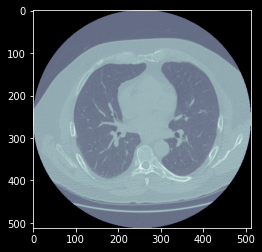

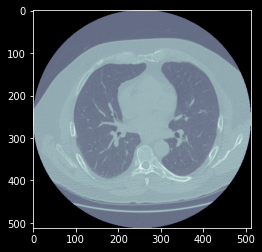

In [7]:
# normalize
img = sitk.ReadImage(ct_path)
arr = sitk.GetArrayFromImage(img)
res_noralize = normalize((arr))
print(res_noralize.max(), res_noralize.min())
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(arr[255], cmap="bone")
plt.show()
plt.close()

plt.figure()
plt.imshow(res_noralize[255], cmap="bone")
plt.show()
plt.close()

In [ ]:
# unify CT thickness
space = img.GetSpacing()
res_unify = unify_slice_thickness(arr, space)
plt.figure()
plt.imshow(res_unify[255], cmap="bone")
print(f"raw arr: {arr.shape}   res_unify shape {res_unify.shape}")
plt.show()
plt.close()

In [19]:
def parenchyma_seg(ct: np.ndarray):
    res = np.zeros_like(ct)
    for i, s in enumerate(ct):
        arr = s.copy()

        # binarize
        threshold = -400
        arr = arr < threshold

        # clear border
        cleared = clear_border(arr)

        # divide into two areas (excluded with background)
        label_img = label(cleared)
        areas = [r.area for r in regionprops(label_img)]
        areas.sort()
        labels = []
        if len(areas) > 2:
            for region in regionprops(label_img):
                if region.area < areas[-2]:
                    for x, y in region.coords:
                        label_img[x, y] = 0
        arr = label_img > 0

        # fill holes
        arr = binary_erosion(arr, disk(2))
        arr = binary_closing(arr, disk(10))
        edges = roberts(arr)
        arr = ndimage.binary_fill_holes(edges)
        res[i] = arr * s
        
    return res

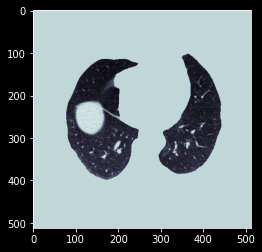

In [20]:
res_seg = parenchyma_seg(arr[200:201])

plt.figure()
plt.imshow(res_seg[0], cmap="bone")
plt.show()
plt.close()

In [ ]:
l

In [ ]:
plt.figure()
plt.imshow(res_seg[300], cmap="Pastel1")
plt.show()
plt.close()